# Show extent of Size Extrapolation, via NNs trained on EMT potential

We want to know how well NNs trained on smaller systems can extrapolate to predict larger systems

The property we are interested in for now is total energy $TE$, from which we can extract atomization energy $AE$,

$AE = TE - \Sigma_i^N {a_i}$

Which is defined as the difference between the total energy $TE$ and the sum of isolated atomic constituents $a_i$

Then, once we've developed a robust NN, we should analyze its accuracy for larger clusters

-----
#### NOTE: <i>Run Programs At Bottom of Notebook First</i>
----

In [2]:
# I will provide the basic building blocks (see programs at the bottom)

## Generation

In [3]:
Z = ['Ag', 'Au', 'Cu', 'Ni', 'Pd', 'Pt']
N = 50 # cluster size
C = 6 # elements per cluster
S = 50 # number of stoichiometries

stois = genStois(Z, N, C, S)

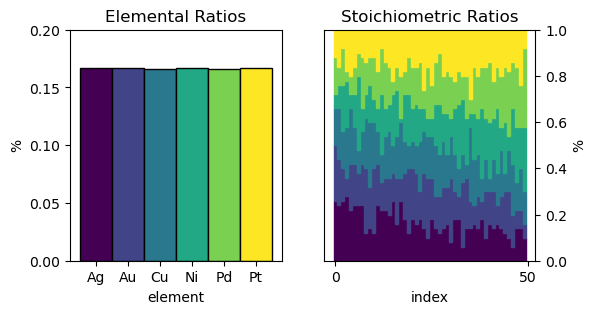

<Figure size 640x480 with 0 Axes>

In [4]:
stoiPlots(stois, 'test')

In [5]:
box = 12 # the square dimension within the cell to generate the positions
# define the basic minimal and maximal inter-atomic distance constraints
dmin = 2.5
dmax = np.sqrt(3)*box

test = genCluster(Atoms(stois[0], cell=[20,20,20], pbc=False))

In [6]:
view(test, viewer='x3d')

In [7]:
clusters = []

# this way, we ensure all elements are equally represented
for stoi in tqdm(stois):
    
    # here we're generating 10 clusters per stoichiometry
    for i in range(10):    
        test = genCluster(Atoms(stoi, cell=[20,20,20], pbc=False))
        test.center()

        # we also want their energies for training
        test.calc = EMT()
        #ae = get_AE(test)
        ae = test.get_potential_energy()
        f = test.get_forces()

        # the NN takes in tensors, so they must be same datatype
        test.calc = SinglePointCalculator(test)
        test.calc.results['energy'] = np.float64(ae)
        test.calc.results['forces'] = np.float64(f)
        clusters.append(test)

print(len(clusters))

100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.42it/s]

500


## Training

In [8]:
# Set up the hyperparameters

epochs = 50 # global dataset passes
batch_size = 20 # samples per weight update
learning_rate = 1e-2 # optimization step size in latent space
features = 100 # vector dimension for atomistic description
interactions = 10 # how many atomistic neighbors influence local features
gaussians = 20 # spatial resolution

# note that the cut-off is defined in multiple places
# so for convenience it's set to 5.5 angstroms for now

# where will we save the results?
directory = 'NNs/testing/'
try: os.mkdir(directory)
except: pass

# generic term for training dataset
images = [clusters[i] for i in np.random.permutation(len(clusters))]

dm = myModule(directory, images, batch_size)
task = myModel(learning_rate, features, interactions, gaussians)
trainer = myTrainer(directory, epochs)

100%|██████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 50.16it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
t1 = time.time()
trainer.fit(task, datamodule=dm)
t2 = time.time()

minutes = round((t2-t1)/60,2)
print('Training complete --', minutes, 'min')

# Note that if you want to suppress some of the benign warnings that show up,
# you can simply stop and reset this code block.

┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model   │ NeuralNetworkPotential │  439 K │
│ 1 │ outputs │ ModuleList             │      0 │
└───┴─────────┴────────────────────────┴────────┘

Trainable params: 439 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 439 K                                                                                                
Total estimated model params size (MB): 1

Output()

/Users/any/miniconda3/envs/shnet/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:77: UserWarning: 
Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 15. To avoid any 
miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(

Metric val_loss improved. New best score: 1.330
Metric val_loss improved by 0.157 >= min_delta = 0.0. New best score: 1.173
Metric val_loss improved by 0.378 >= min_delta = 0.0. New best score: 0.795
Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.783
Metric val_loss improved by 0.357 >= min_delta = 0.0. New best score: 0.426
Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.406
Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 0.306


Epoch 00016: reducing learning rate of group 0 to 7.5000e-03.

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 0.240
Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.204


Epoch 00028: reducing learning rate of group 0 to 5.6250e-03.

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.172


Epoch 00039: reducing learning rate of group 0 to 4.2188e-03.

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 0.084


Epoch 00050: reducing learning rate of group 0 to 3.1641e-03.

`Trainer.fit` stopped: `max_epochs=50` reached.


Training complete -- 16.73 min


In [11]:
# Now that we've trained a network, we must analyze its prowess
directory = 'NNs/testing/'
calc = LoadSchNetCalc(directory, 5.5)

INFO:schnetpack.interfaces.ase_interface:Loading model from NNs/testing/best_inference_model


In [12]:
results = internal(directory, calc)

MAEs = [results[0][4], results[0][5], 
		results[1][4], results[1][5], 
		results[2][4], results[2][5]]

# we can save these MAEs (mean absolute errors) if we wish
np.save(directory+'maes.npy', MAEs)

predicting train data: 100%|█████████████████████████████████████████████| 350/350 [00:18<00:00, 19.17it/s]


oopsies: 0


predicting valid data: 100%|███████████████████████████████████████████████| 75/75 [00:03<00:00, 19.40it/s]


oopsies: 0


predicting test data: 100%|████████████████████████████████████████████████| 75/75 [00:04<00:00, 18.68it/s]


oopsies: 0


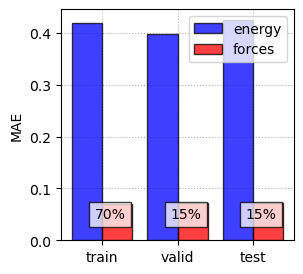

<Figure size 640x480 with 0 Axes>

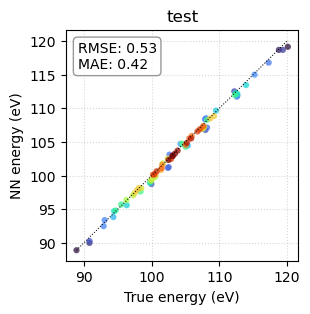

<Figure size 640x480 with 0 Axes>

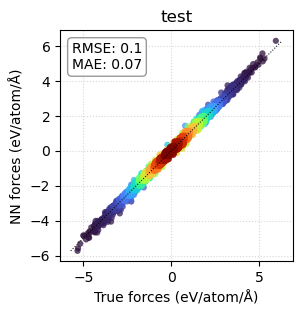

<Figure size 640x480 with 0 Axes>

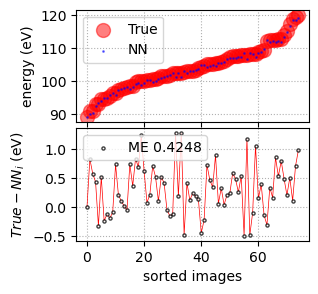

<Figure size 640x480 with 0 Axes>

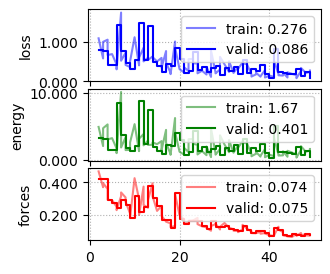

<Figure size 640x480 with 0 Axes>

In [13]:
testE = [results[2][0], results[2][1]]
testF = [results[2][2], results[2][3]]

save = False # save images?
title = 'test' # unique identifier

barplot(directory, MAEs, save)
newplot(directory, 'energy', testE[0], testE[1], title, save)
newplot(directory, 'force', testF[0], testF[1], title, save)
deltaplot(directory, 'energy', testE[0], testE[1], title, save)
trainplot(directory, save)

### As you can see the EMT potential is pretty simple, and hence easy to train on

however this is not true for complicated potentials like DFT.

Regardless, we'll now test out size extrapoation.

## Size Extrapolation

We want to test how this network trained only on size $N$ clusters can predict the energies and forces for larger clusters

In [14]:
# Let's generate some larger clusters and see how well the NN predicts their energies

sizes = np.arange(1,11)*10
print('sizes =', sizes)

cell = [20, 20, 20] # would need bigger cell if testing clusters > 100 atoms
S = 10 # 10 unique stois this time is enough
boxes = np.linspace(8, 16, 10) # bigger clusters require bigger generation box
dmin = 2.3 # allow for close atoms to get strong positive forces
dmax = np.sqrt(3)*box

clusters = []

# Same thing as before, just now with different sizes
for i in tqdm(range(len(sizes))):
    box = boxes[i]
    for j in range(100): # 100 random stois per size
        stoi = np.random.choice(Z, sizes[i])
        test = genCluster(Atoms(stoi, cell=cell, pbc=False))
        try:
            test.calc = EMT()
            e = test.get_potential_energy()
            f = test.get_forces()
            test.calc = SinglePointCalculator(test)
            test.calc.results['energy'] = np.float64(e)
            test.calc.results['forces'] = np.float64(f)
            clusters.append(test)
        except: print('probably need to adjust box, cell, dmin, or dmax'); break
print(len(clusters))

sizes = [ 10  20  30  40  50  60  70  80  90 100]


100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.84s/it]

1000


In [16]:
# now we can test the NN against these images
val, inval, res = external(clusters, calc, limit=100)
# the limit keyword argument sets the upperbound for True-Pred values,
# anything beyond that is reported as an 'oopsie' and saved in the invalid array

predicting images: 100%|███████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.37it/s]


oopsies: 0


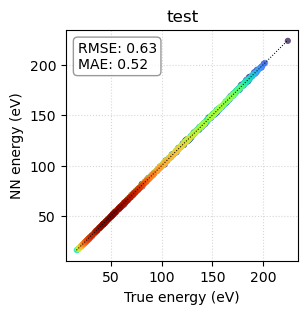

<Figure size 640x480 with 0 Axes>

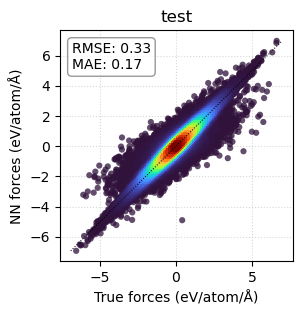

<Figure size 640x480 with 0 Axes>

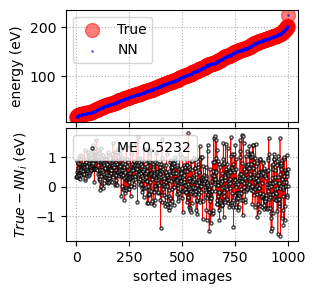

<Figure size 640x480 with 0 Axes>

In [17]:
title = 'test'
save = False

newplot(directory, 'energy', res[0], res[1], title, save)
newplot(directory, 'force', res[2], res[3], title, save)
deltaplot(directory, 'energy', res[0], res[1], title, save)

### It is surprisingly good up to the larger clusters, where it starts getting above 1 eV errors

Of course it has no issues with forces, but with energies it does, as that is a function of cluster size.

There is much we can do here, for now we can train on a larger set of sizes and see if it does better?

In [ ]:
write('DBs/tested_clusters.db', clusters)

### For convenience we'll put all the programs down here for now.
Note that you still must run this cell first

In [1]:
#!/usr/bin/env python3

import os, time, random
import torch, torchmetrics
import schnetpack as spk
import pytorch_lightning as pl
from schnetpack.data import ASEAtomsData, AtomsDataModule
from pytorch_lightning.callbacks import RichProgressBar

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
from scipy.stats import gaussian_kde, lognorm
from scipy.signal import fftconvolve
from collections import Counter
from collections.abc import Iterable

from ase.db import connect
from ase.io import read, write, Trajectory
from ase.atoms import Atoms
from ase.visualize import view
from ase.constraints import *
from ase.calculators.emt import EMT
from ase.optimize import BFGS
from ase.build import molecule

from ase.db import connect
from ase.io import read, write
from ase.io.vasp import read_vasp_out
from ase.calculators.singlepoint import SinglePointCalculator
from ase.data import chemical_symbols

###------------------------------------------
### CLUSTER FUNCTIONS
###------------------------------------------

def genCluster(test):

	cluster = test.copy()
	iterations = 10000
	positions = []
	
	while len(positions) < len(cluster) and iterations>0:
	
		point = np.random.uniform(0, box, size=3)
		if positions:
			distances = np.linalg.norm(np.array(positions)-point, axis=1)
			if not all(dmin < d < dmax for d in distances):
				iterations -= 1
				continue
		positions.append(point)
		iterations-=1
	
	if iterations>0: 
		cluster.positions = positions
		cluster.center()
		return cluster
	else: print('failed'); return None

def relaxCluster(test, calc, steps=250):
	
	cluster = test.copy()
	cluster.calc = calc
	sim = BFGS(cluster, trajectory=None, logfile=None)
	sim.run(fmax=0.01, steps=steps)
	cluster.center()
	return cluster

###------------------------------------------
### UTILITY FUNCTIONS
###------------------------------------------

EMT_energies = {'Ag': 2.96, 'Au': 3.8, 'Cu': 3.51, 'Ni': 4.44, 'Pd': 3.9, 'Pt': 5.85}

def get_AE(test): # get atomization energy
	stoi = test.get_chemical_symbols()
	TE = test.get_potential_energy()
	AE = TE - np.sum([EMT_energies[s] for s in stoi])
	return AE/len(test)

def trueFlat(A): #flattens ragged nested arrays
	for a in A:
		if isinstance(a,Iterable) and not isinstance(a,(str,bytes)): 
			yield from trueFlat(a)
		else: yield a

#gnerates random but even set of stois
def genStois(Z, N, C, S, max_attempts=1000):

	def generate_random_stoich():
		elements = random.sample(Z, C)
		stoi = random.choices(elements, k=N)
		return tuple(sorted(stoi))  # Sort the stoichiometry

	def distribution_score(stoichiometries):
		flat_list = [elem for stoi in stoichiometries for elem in stoi]
		counts = Counter(flat_list)
		ideal_count = len(flat_list)/len(Z)
		return sum((count - ideal_count)**2 for count in counts.values())

	stoichiometries = set()
	attempts = 0
	all_elements_present = False

	while (len(stoichiometries) < S or not all_elements_present) and attempts < max_attempts:
		
		stoi = generate_random_stoich()
		if stoi not in stoichiometries:
			stoichiometries.add(stoi)
			present_elements = set(elem for s in stoichiometries for elem in s)
			all_elements_present = (present_elements == set(Z))
		attempts += 1

	if len(stoichiometries) < S or not all_elements_present:
		print('failed to generate', S, 'unique stoichiometries')

	stoichiometries = sorted(list(stoichiometries))[:S]

	# Improve distribution
	for _ in range(max_attempts):
		initial_score = distribution_score(stoichiometries)
		
		i = random.randint(0, S-1)
		new_stoi = generate_random_stoich()
		
		if new_stoi not in stoichiometries:
			temp_stoi = stoichiometries.copy()
			temp_stoi[i] = new_stoi
			temp_stoi.sort()
			
			if len(set(elem for stoi in temp_stoi for elem in stoi)) == len(Z):
				if distribution_score(temp_stoi) < initial_score:
					stoichiometries = temp_stoi

	return np.array(stoichiometries)

#Analyzes NN preformance against itself
def internal(directory, calc, limit=10.0):

	db = connect(os.path.join(directory, 'new_dataset.db'))
	images = [db.get_atoms(id=j+1) for j in range(len(db))]
	splitfile = np.load(os.path.join(directory, 'split.npz'))
	splits = [splitfile[i] for i in splitfile]
	measures = []
	names = ['train', 'valid', 'test']
	oops = 0

	for i in range(len(splits)):

		trueE = []; predE = []
		trueF = []; predF = []

		for j in tqdm(range(len(splits[i])), desc='predicting '+names[i]+' data'):
			image = images[splits[i][j]]
			tE = image.get_potential_energy()
			tF = image.get_forces()
			copy = image.copy()
			copy.calc = calc
			pE = copy.get_potential_energy()
			pF = copy.get_forces()
			if abs(tE-pE)<limit and (abs(tF-pF)<limit).all():
				trueE.append(tE)
				trueF.append(tF)
				predE.append(pE)
				predF.append(pF)
			else: oops+=1

		print('oopsies:', oops)
		trueE = np.array(list(trueFlat(trueE)))
		predE = np.array(list(trueFlat(predE)))
		trueF = np.array(list(trueFlat(trueF)))
		predF = np.array(list(trueFlat(predF)))
		MAEe = np.mean(np.abs(trueE-predE))
		MAEf = np.mean(np.abs(trueF-predF))
		measures.append([trueE, predE, trueF, predF, MAEe, MAEf])

	return measures

# Analyzes NN against external dataset
def external(images, calc, limit=10.0):
	
	trueE = []; predE = []
	trueF = []; predF = []
	valid = []; inval = []
	oops = 0
	
	for i in tqdm(range(len(images)), desc='predicting images'):
		
		image = images[i]
		tE = image.get_potential_energy()
		tF = image.get_forces()
		copy = image.copy()
		copy.calc = calc
		pE = copy.get_potential_energy()
		pF = copy.get_forces()
		
		if abs(tE-pE)<limit and (abs(tF-pF)<limit).all():
			trueE.append(tE)
			trueF.append(tF)
			predE.append(pE)
			predF.append(pF)
			valid.append(image)
		else: 
			oops+=1
			inval.append(image)
			
	print('oopsies:', oops)
	trueE = np.array(list(trueFlat(trueE)))
	predE = np.array(list(trueFlat(predE)))
	trueF = np.array(list(trueFlat(trueF)))
	predF = np.array(list(trueFlat(predF)))
	MAEe = np.mean(np.abs(trueE-predE))
	MAEf = np.mean(np.abs(trueF-predF))
	measures = [trueE, predE, trueF, predF, MAEe, MAEf]

	return valid, inval, measures


###------------------------------------------
### NETWORK FUNCTIONS
###------------------------------------------

def LoadSchNetCalc(directory, cutoff):

	calculator = spk.interfaces.SpkCalculator(
		model_file=os.path.join(directory, 'best_inference_model'),
		neighbor_list=spk.transform.ASENeighborList(cutoff=cutoff),
		energy_key='energy',
		force_key='forces',
		energy_unit='eV',
		force_units='eV/Ang',
		position_unit='Ang',
	)
	return calculator

def myModule(directory, images, bs):

	#First convert images to ASEAtomsData
	try: os.remove(os.path.join(directory, 'new_dataset.db'))
	except: pass

	property_list = []
	for i in images:
		energy = np.array([i.get_potential_energy()])
		forces = np.array(i.get_forces())
		property_list.append({'energy': energy, 'forces': forces})

	new_dataset = ASEAtomsData.create(
		os.path.join(directory, 'new_dataset.db'), 
		distance_unit='Ang',
		property_unit_dict={'energy':'eV/Ang', 'forces':'eV/Ang'}
	)

	new_dataset.add_systems(property_list, images)

	#Now wrap AtomsData in DataModule class
	DM = AtomsDataModule(
		os.path.join(directory, 'new_dataset.db'),
		split_file = os.path.join(directory, 'split.npz'),
		batch_size=bs, val_batch_size=bs, test_batch_size=bs,
		num_train=int(0.7*len(images)), 
		num_val=int(0.15*len(images)), 
		num_test=int(0.15*len(images)),
		load_properties = ['energy', 'forces'],
		transforms=[
			spk.transform.ASENeighborList(cutoff=5.5),
			spk.transform.RemoveOffsets('energy', remove_mean=True, remove_atomrefs=False),
			spk.transform.CastTo32()
		],
		num_workers=0, #cores
		pin_memory=False, # set to false, when not using a GPU
	)

	DM.prepare_data()
	DM.setup()

	return DM

def myModel(lr, features, interactions, gaussians):

	cutoff = 5.5
	
	#Build model
	radial_basis = spk.nn.GaussianRBF(n_rbf=gaussians, cutoff=cutoff)
	schnet = spk.representation.SchNet(
		n_atom_basis=features, n_interactions=interactions,
		radial_basis=radial_basis,
		cutoff_fn=spk.nn.CosineCutoff(cutoff)
	)
	
	#Assign training features
	pred_energy = spk.atomistic.Atomwise(n_in=features, output_key='energy')
	pred_forces = spk.atomistic.Forces(energy_key='energy', force_key='forces')
	
	#Build potential
	nnpot = spk.model.NeuralNetworkPotential(
		representation=schnet,
		input_modules=[spk.atomistic.PairwiseDistances()],
		output_modules=[pred_energy, pred_forces],
		postprocessors=[
			spk.transform.CastTo64(),
			spk.transform.AddOffsets('energy', add_mean=True, add_atomrefs=False)
		]
	)
	
	#Define loss weights for features
	output_energy = spk.task.ModelOutput(
		name='energy',
		loss_fn=torch.nn.SmoothL1Loss(beta=0.1),
		loss_weight=0.15,
		metrics={"MAE": torchmetrics.MeanAbsoluteError()}
	)
	output_forces = spk.task.ModelOutput(
		name='forces',
		loss_fn=torch.nn.SmoothL1Loss(beta=0.1),
		loss_weight=0.85,
		metrics={"MAE": torchmetrics.MeanAbsoluteError()}
	)
	
	scheduler_args = {'mode': 'min', 'factor': 0.75, 'patience': 5, 
						'threshold': 5e-3, 'threshold_mode': 'rel', 
						'cooldown': 5, 'min_lr': 0, 'verbose':True,
	}

	#Define task
	task = spk.task.AtomisticTask(
		model=nnpot,
		outputs=[output_energy, output_forces],
		optimizer_cls=torch.optim.AdamW,
		optimizer_args={'lr': lr},
		scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
		scheduler_monitor='val_loss',
		scheduler_args=scheduler_args,
	)

	return task

def myTrainer(directory, epochs):

	#Assign logs
	#logger = pl.loggers.TensorBoardLogger(save_dir=directory)
	logger = pl.loggers.CSVLogger(save_dir=directory)
	callbacks = [
		RichProgressBar(),
		spk.train.ModelCheckpoint(
			model_path=os.path.join(directory, 'best_inference_model'),
			save_top_k=1,
			monitor='val_loss'
		),
		pl.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=True),
	]
	
	#Define trainer
	trainer = pl.Trainer(
		accelerator='auto',
		callbacks=callbacks,
		logger=logger,
		log_every_n_steps=10,
		default_root_dir=directory,
		max_epochs=epochs,
		#enable_progress_bar=False,
	)
	
	return trainer

###------------------------------------------
### PLOTTING FUNCTIONS
###------------------------------------------

def stoiPlots(Stois, name, save=False):

	def CoM(inner_list):
		positions = range(1, len(inner_list)+1)
		return sum(p*w for p, w in zip(positions, inner_list))/sum(inner_list)

	plt.rcParams['figure.facecolor'] = 'None'
	plt.rcParams['axes.facecolor'] = 'None'
	f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
	colors = plt.cm.viridis(np.linspace(0, 1, 6))
	E = list(trueFlat(list(trueFlat(Stois))))
	hist, bins, patch = ax1.hist(np.sort(E), bins=np.arange(7)-0.5, width=1, edgecolor='k', density=True)
	for i in range(6):
		patch[i].set_facecolor(colors[i])
	
	ax1.set_xticks(np.arange(6))
	ax1.set_yticks(np.linspace(0,0.2,5))
	ax1.set_title('Elemental Ratios')
	ax1.set_ylabel('%')
	ax1.set_xlabel('element')

	counts = [list(np.unique(s, return_counts=True)[1]) for s in Stois]
	
	s = len(counts)
	n = len(counts[0])

	normalized = [[x/sum(i) for x in i] for i in counts]
	
	values = [CoM(i) for i in normalized]
	index = np.argsort(values)
	sort = [normalized[i] for i in index]
	
	base_sorted = np.zeros(s)
	colors = plt.cm.viridis(np.linspace(0, 1, n))
	for i, inner_list in enumerate(zip(*sort)):
		ax2.bar(range(s), inner_list, bottom=base_sorted, color=colors[i], edgecolor=colors[i])
		base_sorted += np.array(inner_list)
	
	ax2.yaxis.tick_right()
	ax2.yaxis.set_label_position('right')
	ax2.set_ylim(0,1)
	ax2.set_xticks(np.linspace(0,len(Stois),2))
	ax2.set_ylabel('%')
	ax2.set_xlabel('index')
	ax2.set_title('Stoichiometric Ratios')
	
	if save: plt.savefig(name+'.png', dpi=100, bbox_inches='tight')
	else: plt.show()
	plt.clf()

def trainplot(directory, save=False):

	format = ticker.FormatStrFormatter('%.3f')

	data = read_csv(directory+'/lightning_logs/version_0/metrics.csv')
	data.fillna(method='ffill', inplace=True)
	epochs = data['epoch']
	metrics = [[data['train_loss'], data['val_loss']],
			   [data['train_energy_MAE'], data['val_energy_MAE']],
			   [data['train_forces_MAE'], data['val_forces_MAE']]]
	skip = int(0.05*len(epochs))
	
	fig, axes = plt.subplots(3, 1, figsize=(3,3), sharex=True)
	labs = ['train', 'valid']
	colors = ['b', 'g', 'r']
	ylabs = ['loss', 'energy', 'forces']
	for i in range(3):
		ax = axes[i]
		for j in range(2):
			last = np.round(metrics[i][j].iloc[-1], 3)
			ax.plot(epochs[skip:], metrics[i][j][skip:], color=colors[i], 
					alpha=0.5*(j+1), label=labs[j]+': '+str(last))
			ax.set_ylabel(ylabs[i])
			ax.grid(ls=':')
			ax.legend(loc='upper right', facecolor='w')
			ax.yaxis.set_major_formatter(format)
	fig.subplots_adjust(wspace=0.03, hspace=0.1)
	if save: plt.savefig(directory+'/train.png', dpi=100, bbox_inches='tight')
	else: plt.show()
	plt.clf()

def barplot(directory, measures, save=False):

	Max = np.max(measures)

	plt.figure(figsize=(3,3))
	plt.bar(np.arange(3)-0.2, [measures[0],measures[2],measures[4]], 
		label='energy', width=0.4, color='b', edgecolor='k', alpha=0.75, zorder=2)
	plt.bar(np.arange(3)+0.2, [measures[1],measures[3],measures[5]], 
		label='forces', width=0.4, color='r', edgecolor='k', alpha=0.75, zorder=2)

	t1 = plt.text(0-0.1, 0.1*Max, '70%', fontsize=10)
	t1.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='k'))
	t2 = plt.text(1-0.1, 0.1*Max, '15%', fontsize=10)
	t2.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='k'))
	t3 = plt.text(2-0.1, 0.1*Max, '15%', fontsize=10)
	t3.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='k'))

	plt.xticks(np.arange(3), ['train', 'valid', 'test'])
	plt.ylabel('MAE')
	plt.legend(facecolor='w'); plt.grid(ls=':', zorder=0)
	if save: plt.savefig(directory+'/bar.png', dpi=100, bbox_inches='tight')
	else: plt.show()
	plt.clf()

def fast_kde(x, y): # not quadradic for large N

	n = len(x)
	factor = n**(-1.0/6.0)
	hx = np.std(x, ddof=1)*factor
	hy = np.std(y, ddof=1)*factor
	bw = max(np.sqrt(hx*hy), 1e-3)
	hx = max(hx, 1e-3)
	hy = max(hy, 1e-3)
	bx = min(int(np.ceil((x.max() - x.min()) / hx)), 300)
	by = min(int(np.ceil((y.max() - y.min()) / hy)), 300)

	counts, xedges, yedges = np.histogram2d(x, y, bins=(bx,by), density=False)

	dx = xedges[1] - xedges[0]
	dy = yedges[1] - yedges[0]
	sx = bw/dx
	sy = bw/dy

	nx = int(6*sx) + 1
	ny = int(6*sy) + 1
	xi = np.linspace(-3*sx, 3*sx, nx)
	yi = np.linspace(-3*sy, 3*sy, ny)
	Xk, Yk = np.meshgrid(xi, yi)
	kernel = np.exp(-0.5*((Xk/sx)**2 + (Yk/sy)**2))
	kernel /= kernel.sum()

	smooth = fftconvolve(counts, kernel, mode='same')
	ix = np.clip(np.searchsorted(xedges, x)-1, 0, bx-1)
	iy = np.clip(np.searchsorted(yedges, y)-1, 0, by-1)

	return smooth[ix, iy]

def newplot(directory, kind, x, y, title, save=False):

	rmse = np.sqrt(np.mean((y - x)**2))
	mae  = np.mean(np.abs(y - x))

	xy = np.vstack([x, y])
	if kind=='energy': z = gaussian_kde(xy)(xy)
	else: z = fast_kde(x, y)
	idx = z.argsort()
	x_plot, y_plot, z_plot = x[idx], y[idx], z[idx]
    
	fig, ax = plt.subplots(figsize=(3,3))
	sc = ax.scatter(x_plot, y_plot, c=z_plot, s=20, cmap='turbo', edgecolor='None', alpha=0.75, zorder=2)
	text = 'RMSE: '+str(round(rmse,2))+'\nMAE: '+str(round(mae, 2))
	line = [min([min(x), min(y)]), max([max(x), max(y)])]
	ax.plot(line, line, c='black', linestyle='dotted', linewidth=0.75, zorder=3)
    
	ax.text(
		0.05, 0.95, text,
		transform=ax.transAxes,
		va='top', ha='left',
		bbox=dict(boxstyle='round, pad=0.3', edgecolor='gray', facecolor='w', alpha=0.8)
	)

	plt.title(title)
	if kind=='energy': 
		ax.set_xlabel('True energy (eV)')
		ax.set_ylabel('NN energy (eV)')
	else:
		ax.set_xlabel('True forces (eV/atom/\u212B)')
		ax.set_ylabel('NN forces (eV/atom/\u212B)')

	#ax.set_aspect('equal', 'box')
	ax.tick_params(direction='out')
	plt.grid(ls=':', alpha=0.5, zorder=0)
	if save: plt.savefig(directory+'/ratio-'+kind+'.png', dpi=100, bbox_inches='tight')
	else: plt.show()
	plt.clf()


def ratioplot(directory, kind, x, y, title, save=False):

	line = [np.min(y), np.max(y)]
	if kind=='energy' or kind=='relax': unit=' (eV)'
	elif kind=='force': unit=' (eV/atom/\u212B)'
	else: print('[either energy, forces, or relax]'); return

	MAE = np.round(np.mean(x-y), 4)

	xy = np.vstack([x,y])
	z = gaussian_kde(xy)(xy)
	idx = z.argsort()
	x, y, z = x[idx], y[idx], z[idx]
	norm = plt.Normalize()
	colors = plt.cm.turbo(norm(z))

	plt.figure(figsize=(3,3))
	plt.plot(line, line, c='black', linestyle='dotted', 
		linewidth=0.75, zorder=3)
	plt.scatter(x, y, facecolor=colors, edgecolor='None', 
		s=20, alpha=0.75, label='MAE '+str(MAE), zorder=2)
	plt.xlabel('True '+kind+unit)
	plt.ylabel('NN '+kind+unit)
	plt.legend(facecolor='w'); plt.grid(ls=':', zorder=0)
	if save: plt.savefig(directory+'/ratio-'+kind+'.png', dpi=100, bbox_inches='tight')
	else: plt.show()
	plt.clf()

def deltaplot(directory, kind, y1, y2, title, save=False):

	if kind=='energy' or kind=='relax': unit=' (eV)'
	elif kind=='force': unit=' (eV/atom/\u212B)'
	else: print('[either energy, forces, or relax]'); return

	ME = np.round(np.mean(np.abs(y1-y2)), 4)

	index = np.argsort(y1)
	y1 = y1[index]; y2 = y2[index]
	line = [np.min(y2), np.max(y2)]

	fig, ax = plt.subplots(figsize=(3,3), nrows=2, ncols=1, sharex=True)
	x = np.arange(len(y1))

	ax[0].scatter(x, y1, label='True', marker='o', s=100, c='r', alpha=0.5, zorder=2)
	ax[0].scatter(x, y2, label='NN', s=1, c='b', alpha=0.5, zorder=3)
	ax[0].legend()
	ax[0].set_ylabel('energy'+unit)
	ax[0].tick_params(labelbottom=False)    
	ax[0].grid(ls=':', zorder=0)

	delta = (y1-y2)
	ax[1].plot(delta, c='r', linewidth=0.5, alpha=1.0, zorder=2)
	ax[1].scatter(x,delta,label='ME '+str(ME), facecolors='w',
		alpha=0.75, edgecolors='k', s=5, zorder=3)
	ax[1].set_ylabel('$True - NN_i$'+unit)
	ax[1].legend(loc='upper left', facecolor='w')
	ax[1].grid(ls=':', zorder=0)

	plt.subplots_adjust(wspace=0.0, hspace=0.05)
	plt.xlabel('sorted images')
	if save: plt.savefig(directory+'/delta-'+str(kind)+'.png', dpi=100, bbox_inches='tight')
	else: plt.show()
	plt.clf()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
